In [1]:
import sys
sys.path.append('/home/diego/Git/thesis-tabtrans')

import numpy as np
import torch
import torch.nn as nn
from utils import training, callback, evaluating, attention, data, plots 
from sklearn import datasets, model_selection
import skorch
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import openml
from sklearn import datasets, model_selection
from skorch.callbacks import Checkpoint, EarlyStopping, LoadInitState, EpochScoring, Checkpoint, TrainEndCheckpoint

In [2]:
task_id = 233093
dataset_name = data.get_dataset_name(task_id)
print(dataset_name)

mfeat-factors


In [3]:
X_train, X_test, y_train, y_test, n_instances, n_labels, n_numerical, n_categories = data.import_data(task_id, "task")

INFO:openml.datasets.dataset:pickle write mfeat-factors


In [4]:
#####################################################
    # Split data
#####################################################

#getting validation indices
train_indices, val_indices = model_selection.train_test_split(np.arange(X_train.shape[0]), test_size=0.333) #1/9 of train is equal to 10% of total

In [5]:
"""
Transformer hyperparameters definition.

n_heads: Number of heads oneach Transformer Encoder.
embed_dim: The embeddings' dimension.
n_layers: Number of stacked Transformer Encoders.
ff_pw_size: Position-wise Feed Forward network hidden layer size.
attn_dropout: Dropout applied in the Multi-head self-attention mechanism.
ff_dropout: Position-wise Feed Forward network dropout.
aggregator: Aggregator to use. Must be in {concatenate, cls, max, mean, sum, rnn}
aggregator_parameters: If the aggregator is different from rnn, set to None. Otherwise, a dictionary expecting:
                        cell: Cellused in the RNN. Must be one of {GRU, LSTM}
                        output_size: Recurrent neural network hidden size 
                        num_layers: Number of stacked layers in the RNN
                        dropout: Dropout applied to the RNN
    }
decoder_hidden_units: List of hidden layer's sizes of the decoder MLP.
decoder_activation_fn: Activation function used in the hidden layers
need_weights: Set True if you require the attention cubes. During training is recommended to set it to False.
numerical_passthrough: False if numerical features will be processed by the Multi-head self-attention mechanism.
"""


n_heads = 4 # In average 4 works better
embed_dim = 256 # In average 256 works better
n_layers = 3
ff_pw_size = 30  #this value because of the paper 
attn_dropout = 0.3 #paper
ff_dropout = 0.1 #paper value
aggregator = "cls"
aggregator_parameters = None
decoder_hidden_units = [128,64] #paper value
decoder_activation_fn = nn.ReLU()
need_weights = False
numerical_passthrough = False


In [6]:
"""
Building PyTorch module.

We provide a wrapper function for building the PyTorch module.
The function is utils.training.build_module.
"""
module = training.build_module(
    n_categories, # List of number of categories
    n_numerical, # Number of numerical features
    n_heads, # Number of heads per layer
    ff_pw_size, # Size of the MLP inside each transformer encoder layer
    n_layers, # Number of transformer encoder layers    
    n_labels, # Number of output neurons
    embed_dim,
    attn_dropout, 
    ff_dropout, 
    aggregator, # The aggregator for output vectors before decoder
    rnn_aggregator_parameters=aggregator_parameters,
    decoder_hidden_units=decoder_hidden_units,
    decoder_activation_fn=decoder_activation_fn,
    need_weights=need_weights,
    numerical_passthrough=numerical_passthrough
)


/home/diego/anaconda3/envs/tabtrans/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [23]:
dir = "/home/diego/Git/thesis-tabtrans/experiments/test_model_values"

In [25]:
model = skorch.NeuralNetClassifier(
            module=module,
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            device="cuda" if torch.cuda.is_available() else "cpu",
            batch_size= 64,
            max_epochs=10,
            train_split=skorch.dataset.ValidSplit(((train_indices, val_indices),)),
            callbacks=[
                ("balanced_accuracy", skorch.callbacks.EpochScoring("balanced_accuracy", lower_is_better=False)),
                ("duration", skorch.callbacks.EpochTimer()),
                EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
                Checkpoint(monitor='valid_acc_best',dirname=dir,load_best = True),
                EarlyStopping(patience=3)

            ],
            optimizer__lr=1e-4,
            optimizer__weight_decay=1e-4
        )


In [26]:
"""
Training and validation
"""
# Define Checkpoint and TrainEndCheckpoint callbacks with custom directory
cp = Checkpoint()
train_end_cp = TrainEndCheckpoint()

model = model.fit(X={
        "x_numerical": X_train[:, :n_numerical].astype(np.float32),
        "x_categorical": X_train[:, n_numerical:].astype(np.int32)
        }, 
        y=y_train.astype(np.int64)
    )

  epoch    balanced_accuracy    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -------------------  -----------  ------------  -----------  ------------  ----  ------
      1               0.8506       0.8294        0.5161       0.8502        0.4446     +  1.7343
      2               0.8488       0.8229        0.5114       0.8483        0.4421        1.7234
      3               0.8479       0.8229        0.5101       0.8483        0.4461        1.7227
      4               0.8495       0.8369        0.4883       0.8483        0.4399        1.7232
      5               0.8534       0.8454        0.4990       0.8539        0.4461     +  1.7238
      6               0.8465       0.8482        0.5000       0.8464        0.4356        1.7232
      7               0.8553       0.8360        0.4874       0.8558        0.4233     +  1.7239
      8               0.8564       0.8388        0.4872       0.8558        0.4229        1.7240
      9               0.8428  

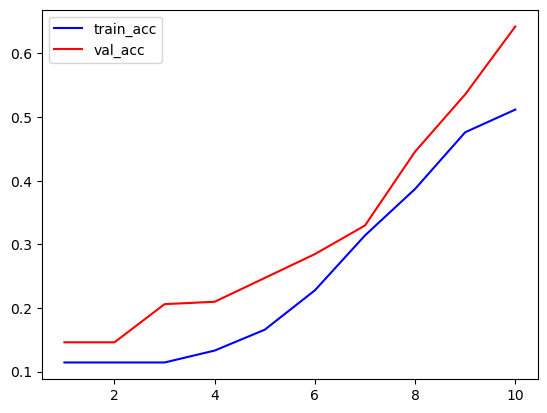

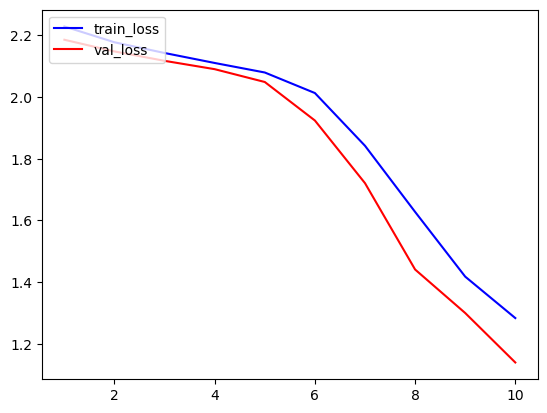

In [9]:
fig_1, fig_2 = plots.model_plots(model)